# Case study 1

In [1]:
import h5py
import numpy as np
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import scipy.stats as stats
import seaborn as sns

#conda install -c conda-forge miktex in command prompt
import seaborn as sns
#from ipywidgets import widgets, Layout-this is optionally, must be installed 
#from IPython import display - this is optionally
#from ipywidgets import widgets, Layout


In [2]:
#FOR LATEX -takes longer to run plots

plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']# all text in blots bold
#plt.rc('text', usetex=True)# for figure export 
plt.rc('text', usetex=False)# use tex for image export
PLTSCALFACTOR =1.5# change this to scale all plots labels (3 is good for export on 4k screan)
SMALL_SIZE = 12 * PLTSCALFACTOR
MEDIUM_SIZE = 15 * PLTSCALFACTOR
BIGGER_SIZE = 18 * PLTSCALFACTOR

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['lines.linewidth'] = PLTSCALFACTOR

<ipython-input-2-06400834ace8>:4: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']# all text in blots bold


# 1.Extract the data

Data for ILC comparison is extracted from the HDF5 files separately for PTB and CEM. The extracted data will be sorted by frequency at the end of the Notebook and saved into Excel file.

In [4]:
def extract_data(filename, sensor_index):
    #explore the HDF5 file, folders and subfolders
    with h5py.File(filename,'r') as f:
        base_items=list(f.items())
        print("\nItems in directory", base_items)
        rawtransfer=f.get("RAWTRANSFERFUNCTION")
        rawtransfer_items=list(rawtransfer.items())
        print("\nItems in reference", rawtransfer_items)
        subgroup=rawtransfer.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250")
        subgroup_items=list(subgroup.items())
        print("\n"+sensor_index+"_MPU_9250 items:",subgroup_items)
        subgroup_acceleration=subgroup.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration")
        subgroup_acceleration_items=list(subgroup_acceleration.items())
        print("\nAcceleration items:",subgroup_acceleration_items)
        subgroup_acceleration_5mem=subgroup.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration")
        subgroup_acceleration_5mem_items=list(subgroup_acceleration_5mem.items())
        print("\nAcceleration items_5members:", subgroup_acceleration_5mem_items)
        frequency=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration/Excitation_frequency")
        frequency_items=list(frequency.items())
        print("\nFrequency", frequency_items)
        magnitude=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration/Magnitude")
        magnitude_items=list(magnitude.items())
        print("\nMagnitude", magnitude_items)
        phase=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration/Phase")
        phase_items=list(magnitude.items())
        print("\nPhase", phase_items)
        
        
        #extract frequencies, magnitude, phase, uncertainties and all excitation parameters
        frequency_values=np.array(frequency.get("value"))
        magnitude_values=np.array(magnitude.get("value"))
        magnitude_uncertainties=np.array(magnitude.get("uncertainty"))
        phase_values=np.array(phase.get("value"))
        phase_uncertainties=np.array(phase.get("uncertainty"))
        excitation_freq_items=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration/Excitation_frequency")
        excitation_freq=np.array(excitation_freq_items.get("value"))
        excitation_amp_items=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration/Excitation_amplitude")
        excitation_amp=np.array(excitation_amp_items.get("value"))
        excitation_amp_uncertainty=np.array(excitation_amp_items.get("uncertainty"))
        
        #join all necessary data in 2D array
        total_array=np.stack((frequency_values,magnitude_values,magnitude_uncertainties,phase_values, phase_uncertainties,excitation_freq,excitation_amp,excitation_amp_uncertainty), axis=1)
        print("\nArray dimensions:", total_array.shape)
        column_names=["Frequency in Hz", r"$|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$",r"$U_{|S(\omega)|}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$", r"$\varphi(\omega)$ in $rad$", r"$U_{\varphi(\omega)}$ in $rad$","Excitation_freq in Hz",r"$A_{excit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$",r"$U_{Aexcit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"]
        whole_dataset=pd.DataFrame(total_array, columns=column_names)
        f.close()
        
        
        return whole_dataset

In [5]:
whole_dataset_PTB = extract_data('MPU9250PTB_v5.hdf5',"0x1fe40000")


Items in directory [('EXPERIMENTS', <HDF5 group "/EXPERIMENTS" (1 members)>), ('RAWDATA', <HDF5 group "/RAWDATA" (2 members)>), ('RAWTRANSFERFUNCTION', <HDF5 group "/RAWTRANSFERFUNCTION" (1 members)>), ('REFERENCEDATA', <HDF5 group "/REFERENCEDATA" (2 members)>)]

Items in reference [('0x1fe40000_MPU_9250', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250" (1 members)>)]

0x1fe40000_MPU_9250 items: [('Acceleration', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250/Acceleration" (1 members)>)]

Acceleration items: [('Acceleration', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250/Acceleration/Acceleration" (11 members)>)]

Acceleration items_5members: [('DUT_Phase', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250/Acceleration/Acceleration/DUT_Phase" (2 members)>), ('DUT_SNYNC_Phase', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250/Acceleration/Acceleration/DUT_SNYNC_Phase" (2 members)>), ('DUT_amplitude', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250/

In [6]:
whole_dataset_PTB.head(2)

Frequency in Hz  \
0             10.0   
1             12.5   

   $|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                           1.019554             
1                                           1.019093             

   $U_{|S(\omega)|}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                           0.003273                 
1                                           0.004047                 

   $\varphi(\omega)$ in $rad$  $U_{\varphi(\omega)}$ in $rad$  \
0                   -0.094684                        0.003022   
1                   -0.118820                        0.006455   

   Excitation_freq in Hz  \
0                   10.0   
1                   12.5   

   $A_{excit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                              2.739           
1                                              2.744           

   $U_{Aexcit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  
0                                           0.004891           
1                                           0.007312

In [7]:
whole_dataset_PTB.head(2)

Frequency in Hz  \
0             10.0   
1             12.5   

   $|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                           1.019554             
1                                           1.019093             

   $U_{|S(\omega)|}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                           0.003273                 
1                                           0.004047                 

   $\varphi(\omega)$ in $rad$  $U_{\varphi(\omega)}$ in $rad$  \
0                   -0.094684                        0.003022   
1                   -0.118820                        0.006455   

   Excitation_freq in Hz  \
0                   10.0   
1                   12.5   

   $A_{excit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                              2.739           
1                                              2.744           

   $U_{Aexcit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  
0                                           0.004891           
1                                           0.007312

In [8]:
whole_dataset_CEM = extract_data('MPU9250CEM_v5.hdf5',"0xbccb0000")


Items in directory [('EXPERIMENTS', <HDF5 group "/EXPERIMENTS" (1 members)>), ('RAWDATA', <HDF5 group "/RAWDATA" (2 members)>), ('RAWTRANSFERFUNCTION', <HDF5 group "/RAWTRANSFERFUNCTION" (1 members)>), ('REFERENCEDATA', <HDF5 group "/REFERENCEDATA" (2 members)>)]

Items in reference [('0xbccb0000_MPU_9250', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250" (1 members)>)]

0xbccb0000_MPU_9250 items: [('Acceleration', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250/Acceleration" (1 members)>)]

Acceleration items: [('Acceleration', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250/Acceleration/Acceleration" (11 members)>)]

Acceleration items_5members: [('DUT_Phase', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250/Acceleration/Acceleration/DUT_Phase" (2 members)>), ('DUT_SNYNC_Phase', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250/Acceleration/Acceleration/DUT_SNYNC_Phase" (2 members)>), ('DUT_amplitude', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250/

In [9]:
whole_dataset_CEM[[r"$\varphi(\omega)$ in $rad$"]] = whole_dataset_CEM[[r"$\varphi(\omega)$ in $rad$"]]-np.pi
whole_dataset_CEM.head(2)

Frequency in Hz  \
0             80.0   
1            250.0   

   $|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                                NaN             
1                                           0.643003             

   $U_{|S(\omega)|}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                                NaN                 
1                                           0.000891                 

   $\varphi(\omega)$ in $rad$  $U_{\varphi(\omega)}$ in $rad$  \
0                         NaN                             NaN   
1                   -2.375412                        0.002897   

   Excitation_freq in Hz  \
0                   80.0   
1                  250.0   

   $A_{excit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                                NaN           
1                                         126.497513           

   $U_{Aexcit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  
0                                                NaN           
1                                           0.125687

Cycles in CEM's dataset start with 80.0 Hz and 250.0 Hz instead of 10.0 Hz. These starting points are deleted in order to compare the cycles in a range from 10.0 Hz and 250.Hz.

In [10]:
delete_rows=[]

for k in range(0,171,19):
    i=k
    j=k+1
    delete_rows.append(i)
    delete_rows.append(j)
whole_dataset_CEM_new=whole_dataset_CEM.drop(axis=0,index=delete_rows)

In [11]:
def split_data_by_frequencies(dataset):
    dict_of_frequencies=dict(iter(dataset.groupby("Frequency in Hz")))
    return dict_of_frequencies
    #list_of_frequencies=np.array([10,12.5,16,20,25,31.5,40,46.7,50,53.3,63,80,100,125,160,200,250])

In [12]:
#check if all frequencies are the same
PTB_separated_by_freq=split_data_by_frequencies(whole_dataset_PTB)
CEM_separated_by_freq=split_data_by_frequencies(whole_dataset_CEM)
CEM_separated_by_freq_new=split_data_by_frequencies(whole_dataset_CEM_new)
print("Frequencies - PTB:",PTB_separated_by_freq.keys())
print("Frequencies - CEM:",CEM_separated_by_freq.keys())

Frequencies - PTB: dict_keys([10.0, 12.5, 16.0, 20.0, 25.0, 31.5, 40.0, 46.7, 50.0, 53.3, 63.0, 80.0, 100.0, 125.0, 160.0, 200.0, 250.0])
Frequencies - CEM: dict_keys([10.0, 12.5, 16.0, 20.0, 25.0, 31.5, 40.0, 46.7, 50.0, 53.3, 63.0, 80.0, 100.0, 125.0, 160.0, 200.0, 250.0])


In [13]:
PTB_separated_by_freq.get(10).head(1)

Frequency in Hz  \
0             10.0   

   $|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                           1.019554             

   $U_{|S(\omega)|}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                           0.003273                 

   $\varphi(\omega)$ in $rad$  $U_{\varphi(\omega)}$ in $rad$  \
0                   -0.094684                        0.003022   

   Excitation_freq in Hz  \
0                   10.0   

   $A_{excit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                              2.739           

   $U_{Aexcit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  
0                                           0.004891

In [14]:
CEM_separated_by_freq_new.get(10).head(1)

Frequency in Hz  \
2             10.0   

   $|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
2                                           1.016209             

   $U_{|S(\omega)|}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
2                                           0.004893                 

   $\varphi(\omega)$ in $rad$  $U_{\varphi(\omega)}$ in $rad$  \
2                   -0.094907                        0.001665   

   Excitation_freq in Hz  \
2                   10.0   

   $A_{excit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
2                                           2.754331           

   $U_{Aexcit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  
2                                            0.00586

In [15]:
q_names=list(PTB_separated_by_freq.get(10).columns)

In [16]:
list_of_freq=[10,12.5,16,20,25,31.5,40,46.7,50,53.3,63,80,100,125,160,200,250]

# 2.  Case study 1: Calculate En values for estimated means and standard deviations (Type A solution)

In the Case study 1, the calculated standard uncertainties of the quantities of interest from different experiments were neglected and it is assumed that they belong to the same distribution.  The estimated mean values for both, magnitude and phase at each frequency are calculated in align with the GUM principle:

## 2.1 The probability distribution

The estimated mean values at each specific frequencies are calculated as:
$${\bar {x}}=\frac {\sum _{i=1}^{n}x_{i}}{n}$$,

where:
<br>x represents the value of an experiment at a specific frequency
<br>n is the number of experiments at a specific frequency.

The observed standard deviation of the single value is *s*, calculated as:
$$s=\sqrt{\frac {\sum _{i=1}^{n}{(x_{i}-\bar {x})}^{2}}{n-1}}$$

Estimated experimental standard deviation to the estimated mean value is:

$$s(\bar {x})=\frac {s}{\sqrt{n}}$$

Note that expanded measurement uncertainty used in this calculation contains only type A information.  

Mean, observed standard deviation and estimated standard deviation to the estimated mean value of all quantities and uncertainties are calculated at every frequency by the function calculate_means_and_std.



In [18]:
def calculate_means_and_std(dictionary,names_mean,names_std,est_names):
    mean_list=[]
    stdev_list=[]
    n_list=[]
    for val in dictionary.values():
        mean_list.append(val.mean())
        stdev_list.append(np.std(val,ddof=1))
        #new part of the code:
        n_list.append(len(val))
    mean_array=np.asarray(mean_list)
    stdev_array=np.asarray(stdev_list)
    n=np.asarray(n_list)
    mean_array=pd.DataFrame(mean_array,columns=names_mean)
    stdev_array=pd.DataFrame(stdev_array,columns=names_std)
    avg_and_std=pd.concat([mean_array,stdev_array],axis=1)
    #new part of the code
    st_dev_estimate=pd.DataFrame(stdev_array.div(np.sqrt(n),axis=0))
    st_dev_estimate.columns=est_names
    st_dev_estimate.rename(columns = {r"$s(\bar{x})$-Frequency [Hz]":"Frequency in Hz"},inplace=True )
    return avg_and_std, st_dev_estimate


In [31]:
column_names1=["Frequency in Hz", r"$\bar{x}_{|S(\omega)|}$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$",r"$\bar{x}_{U_|S(\omega)|}$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$", r"$\bar{x}_{\varphi(\omega)}$ in $rad$", r"$\bar{x}_{U_\varphi(\omega)}$ in $rad$",r"$\bar{x}_{ex_freq}$ in $Hz$",r"$\bar{x}_{Aexcit}$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$",r"$\bar{x}_{U_Aexcit}$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"]
column_names2=["Frequency in Hz", r"$s(x_{|S(\omega)|})$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$",r"$s(x_{U_|S(\omega)|})$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$", r"$s(x_{\varphi(\omega)})$ in $rad$", r"$s(x_{U_\varphi(\omega)})$ in $rad$",r"$s(x_{ex_freq})$ in $Hz$",r"$s(x_{Aexcit})$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$",r"$s(x_{U_Aexcit})$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"]
column_names3=["Frequency in Hz", r"$s(\bar{x}_{|S(\omega)|})$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$",r"$\bar{x}_{U_|S(\omega)|}$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$", r"$s(\bar{x}_{\varphi(\omega)})$ in $rad$", r"$s(\bar{x}_{U_\varphi(\omega)})$ in $rad$",r"$s(\bar{x}_{ex_freq})$ in $Hz$",r"$s(\bar{x}_{Aexcit})$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$",r"$s(\bar{x}_{U_Aexcit})$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"]


avg_std_PTB,st_sample_PTB=calculate_means_and_std(PTB_separated_by_freq,column_names1,column_names2,column_names3)
avg_std_CEM,st_sample_CEM=calculate_means_and_std(CEM_separated_by_freq_new,column_names1,column_names2,column_names3)

st_sample_PTB["Frequency in Hz"]=list_of_freq
st_sample_CEM["Frequency in Hz"]=list_of_freq

avg_std_PTB .head(2)

Frequency in Hz  \
0             10.0   
1             12.5   

   $\bar{x}_{|S(\omega)|}$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                           1.019172                      
1                                           1.018422                      

   $\bar{x}_{U_|S(\omega)|}$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                           0.004445                        
1                                           0.005487                        

   $\bar{x}_{\varphi(\omega)}$ in $rad$  \
0                             -0.094700   
1                             -0.118714   

   $\bar{x}_{U_\varphi(\omega)}$ in $rad$  $\bar{x}_{ex_freq}$ in $Hz$  \
0                                0.003140                         10.0   
1                                0.005047                         12.5   

   $\bar{x}_{Aexcit}$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                             2.7511                 
1                                             2.7559                 

   $\bar{x}_{U_Aexcit}$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                           0.007736                   
1                                           0.010247                   

   Frequency in Hz  \
0              0.0   
1              0.0   

   $s(x_{|S(\omega)|})$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                           0.000186                   
1                                           0.000349                   

   $s(x_{U_|S(\omega)|})$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                           0.001267                     
1                                           0.001632                     

   $s(x_{\varphi(\omega)})$ in $rad$  $s(x_{U_\varphi(\omega)})$ in $rad$  \
0                           0.000146                             0.000423   
1                           0.000400                             0.000963   

   $s(x_{ex_freq})$ in $Hz$  \
0                       0.0   
1                       0.0   

   $s(x_{Aexcit})$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                           0.005896              
1                                           0.005174              

   $s(x_{U_Aexcit})$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  
0                                           0.002606               
1                                           0.003836

In [32]:
avg_std_CEM.head(2)

Frequency in Hz  \
0             10.0   
1             12.5   

   $\bar{x}_{|S(\omega)|}$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                           1.016157                      
1                                           1.015931                      

   $\bar{x}_{U_|S(\omega)|}$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                           0.003945                        
1                                           0.002947                        

   $\bar{x}_{\varphi(\omega)}$ in $rad$  \
0                              -0.09491   
1                              -0.11858   

   $\bar{x}_{U_\varphi(\omega)}$ in $rad$  $\bar{x}_{ex_freq}$ in $Hz$  \
0                                0.001690                         10.0   
1                                0.001982                         12.5   

   $\bar{x}_{Aexcit}$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                           2.753239                 
1                                           2.729542                 

   $\bar{x}_{U_Aexcit}$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                           0.004646                   
1                                           0.004458                   

   Frequency in Hz  \
0              0.0   
1              0.0   

   $s(x_{|S(\omega)|})$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                           0.001688                   
1                                           0.000414                   

   $s(x_{U_|S(\omega)|})$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                           0.001245                     
1                                           0.000525                     

   $s(x_{\varphi(\omega)})$ in $rad$  $s(x_{U_\varphi(\omega)})$ in $rad$  \
0                           0.000206                             0.000057   
1                           0.000207                             0.000057   

   $s(x_{ex_freq})$ in $Hz$  \
0                       0.0   
1                       0.0   

   $s(x_{Aexcit})$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  \
0                                           0.003266              
1                                           0.003683              

   $s(x_{U_Aexcit})$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$  
0                                           0.000787               
1                                           0.001069

In [33]:
def plot_Magnitude(dataset,mean_stdev,est_stdev,dataset1,mean_stdev1,est_stdev1):
    fig, ax = plt.subplots(nrows=len(dataset),ncols=2,figsize=(28,180))

    for i,val in enumerate(dataset.values()):
        
        x=np.linspace(0,len(val),len(val))
        y= val[ r"$|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"].values
        error=est_stdev[est_stdev["Frequency in Hz"]==val["Frequency in Hz"].values[0]]
        y1=mean_stdev[r"$\bar{x}_{|S(\omega)|}$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"][i]+mean_stdev[r"$s(x_{|S(\omega)|})$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"][i]
        y2=mean_stdev[r"$\bar{x}_{|S(\omega)|}$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"][i]-mean_stdev[r"$s(x_{|S(\omega)|})$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"][i]
        y3=mean_stdev[r"$\bar{x}_{|S(\omega)|}$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"][i]+est_stdev[r"$s(\bar{x}_{|S(\omega)|})$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"][i]
        y4=mean_stdev[r"$\bar{x}_{|S(\omega)|}$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"][i]-est_stdev[r"$s(\bar{x}_{|S(\omega)|})$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"][i]
        y5=mean_stdev[r"$\bar{x}_{|S(\omega)|}$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"][i]
        ax[i,0].errorbar(x, y,yerr=np.ones(len(val))*error[r"$s(\bar{x}_{|S(\omega)|})$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"].values, linestyle="",marker="o",label="Experiments")
        ax[i,0].hlines(y=y1,xmin=x[0],xmax=x[-1], color="blue", label=r"$\bar{S(\omega)}+s(S(\omega))$")
        ax[i,0].hlines(y=y2,xmin=x[0],xmax=x[-1], color="blue", label=r"$\bar{S(\omega)}-s(S(\omega))$")
        ax[i,0].hlines(y=y3,xmin=x[0],xmax=x[-1], color="red", label=r"$\bar{S(\omega)}+s(\bar{S(\omega)})$")
        ax[i,0].hlines(y=y4,xmin=x[0],xmax=x[-1], color="red", label=r"$\bar{S(\omega)}-s(\bar{S(\omega)})$")
        ax[i,0].hlines(y=y5,xmin=x[0],xmax=x[-1], color="green", label=r"$\bar{S(\omega)}$")
        ax[i,0].set_title( str(val["Frequency in Hz"].values[0])+" Hz - PTB")
        ax[i,0].set_ylabel(r"$S(\omega)$ in $\frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$")
        ax[i,0].set_xlabel("Experiments")
        ax[i,0].legend(loc="best")
        ax[i,0].fill_between(x,y1,y2,color="yellow")
        ax[i,0].fill_between(x,y3,y4,color="beige")
    
       
        
    for i,val in enumerate(dataset1.values()):
        x=np.linspace(0,len(val),len(val))
        y= val[r"$|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"].values
        error=est_stdev1[est_stdev1["Frequency in Hz"]==val["Frequency in Hz"].values[0]]
        y1=mean_stdev1[r"$\bar{x}_{|S(\omega)|}$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"][i]+mean_stdev1[r"$s(x_{|S(\omega)|})$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"][i]
        y2=mean_stdev1[r"$\bar{x}_{|S(\omega)|}$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"][i]-mean_stdev1[r"$s(x_{|S(\omega)|})$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"][i]
        y3=mean_stdev1[r"$\bar{x}_{|S(\omega)|}$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"][i]+est_stdev1[r"$s(\bar{x}_{|S(\omega)|})$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"][i]
        y4=mean_stdev1[r"$\bar{x}_{|S(\omega)|}$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"][i]-est_stdev1[r"$s(\bar{x}_{|S(\omega)|})$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"][i]
        y5=mean_stdev1[r"$\bar{x}_{|S(\omega)|}$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"][i]
        ax[i,1].errorbar(x, y,yerr=np.ones(len(val))*error[r"$s(\bar{x}_{|S(\omega)|})$in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"].values, linestyle="",marker="o",label="Experiments")
        ax[i,1].hlines(y=y1,xmin=x[0],xmax=x[-1], color="blue", label=r"$\bar{S(\omega)}+s(S(\omega))$")
        ax[i,1].hlines(y=y2,xmin=x[0],xmax=x[-1], color="blue", label=r"$\bar{S(\omega)}-s(S(\omega))$")
        ax[i,1].hlines(y=y3,xmin=x[0],xmax=x[-1], color="red", label=r"$\bar{S(\omega)}+s(\bar{S(\omega)})$")
        ax[i,1].hlines(y=y4,xmin=x[0],xmax=x[-1], color="red", label=r"$\bar{S(\omega)}-s(\bar{S(\omega)})$")
        ax[i,1].hlines(y=y5,xmin=x[0],xmax=x[-1], color="green", label=r"$\bar{S(\omega)}$")
        ax[i,1].set_title(str(val["Frequency in Hz"].values[0])+" Hz - CEM")
        ax[i,1].set_ylabel(r"$S(\omega)$ in $\frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$")
        ax[i,1].set_xlabel("Experiments")
        ax[i,1].legend(loc="best")
        ax[i,1].fill_between(x,y1,y2,color="yellow")
        ax[i,1].fill_between(x,y3,y4,color="beige")
    
    plt.show()

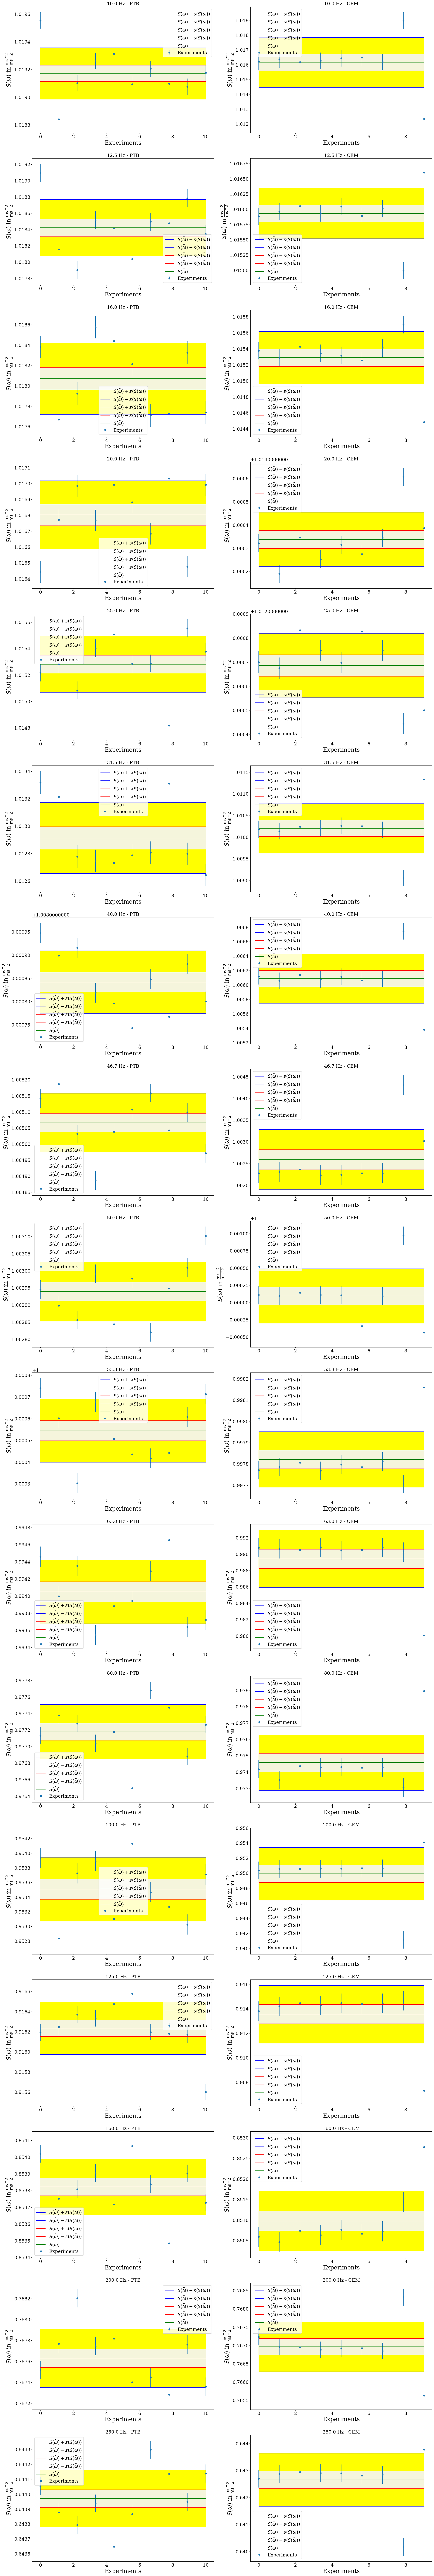

In [34]:
plot_Magnitude(PTB_separated_by_freq,avg_std_PTB,st_sample_PTB,CEM_separated_by_freq_new,avg_std_CEM,st_sample_CEM)

In [37]:

def plot_phase(dataset,mean_stdev,est_stdev,dataset1,mean_stdev1,est_stdev1):
    fig, ax = plt.subplots(nrows=len(dataset),ncols=2,figsize=(28,180))
    for i,val in enumerate(dataset.values()):
        
        x=np.linspace(0,len(val),len(val))
        y= np.rad2deg(val[r"$\varphi(\omega)$ in $rad$"].values)
        error=est_stdev[est_stdev["Frequency in Hz"]==val["Frequency in Hz"].values[0]]
        y1=np.rad2deg(mean_stdev[r"$\bar{x}_{\varphi(\omega)}$ in $rad$"][i]+mean_stdev[r"$s(x_{\varphi(\omega)})$ in $rad$"][i])
        y2=np.rad2deg(mean_stdev[r"$\bar{x}_{\varphi(\omega)}$ in $rad$"][i]-mean_stdev[r"$s(x_{\varphi(\omega)})$ in $rad$"][i])
        y3=np.rad2deg(mean_stdev[r"$\bar{x}_{\varphi(\omega)}$ in $rad$"][i]+est_stdev[r"$s(\bar{x}_{\varphi(\omega)})$ in $rad$"][i])
        y4=np.rad2deg(mean_stdev[r"$\bar{x}_{\varphi(\omega)}$ in $rad$"][i]-est_stdev[r"$s(\bar{x}_{\varphi(\omega)})$ in $rad$"][i])
        y5=np.rad2deg(mean_stdev[r"$\bar{x}_{\varphi(\omega)}$ in $rad$"][i])
        ax[i,0].errorbar(x, y,yerr=np.ones(len(val))*np.rad2deg(error[r"$s(\bar{x}_{\varphi(\omega)})$ in $rad$"].values), linestyle="",marker="o",label="Experiments")
        ax[i,0].hlines(y=y1,xmin=x[0],xmax=x[-1], color="blue", label=r"$\bar{\varphi(\omega)}+s(\varphi(\omega))$")
        ax[i,0].hlines(y=y2,xmin=x[0],xmax=x[-1], color="blue", label=r"$\bar{\varphi(\omega)}-s(\varphi(\omega))$")
        ax[i,0].hlines(y=y3,xmin=x[0],xmax=x[-1], color="red", label=r"$\bar{\varphi(\omega)}+s(\bar{\varphi(\omega)})$")
        ax[i,0].hlines(y=y4,xmin=x[0],xmax=x[-1], color="red", label=r"$\bar{\varphi(\omega)}-s(\bar{\varphi(\omega)})$")
        ax[i,0].hlines(y=y5,xmin=x[0],xmax=x[-1], color="green", label=r"$\bar{\varphi(\omega)}$")
        ax[i,0].set_title(str(val["Frequency in Hz"].values[0])+" Hz - PTB")
        ax[i,0].set_ylabel(r"$\varphi(\omega)$ in$^\circ$")
        ax[i,0].set_xlabel("Experiments")
        ax[i,0].legend(loc="best")
        ax[i,0].fill_between(x,y1,y2,color="yellow")
        ax[i,0].fill_between(x,y3,y4,color="beige")
       
    for i,val in enumerate(dataset1.values()):  
        x=np.linspace(0,len(val),len(val))
        y= np.rad2deg(val[r"$\varphi(\omega)$ in $rad$"].values)
        error=est_stdev1[est_stdev1["Frequency in Hz"]==val["Frequency in Hz"].values[0]]
        y1=np.rad2deg(mean_stdev1[r"$\bar{x}_{\varphi(\omega)}$ in $rad$"][i]+mean_stdev1[r"$s(x_{\varphi(\omega)})$ in $rad$"][i])
        y2=np.rad2deg(mean_stdev1[r"$\bar{x}_{\varphi(\omega)}$ in $rad$"][i]-mean_stdev1[r"$s(x_{\varphi(\omega)})$ in $rad$"][i])
        y3=np.rad2deg(mean_stdev1[r"$\bar{x}_{\varphi(\omega)}$ in $rad$"][i]+est_stdev1[r"$s(\bar{x}_{\varphi(\omega)})$ in $rad$"][i])
        y4=np.rad2deg(mean_stdev1[r"$\bar{x}_{\varphi(\omega)}$ in $rad$"][i]-est_stdev1[r"$s(\bar{x}_{\varphi(\omega)})$ in $rad$"][i])
        y5=np.rad2deg(mean_stdev1[r"$\bar{x}_{\varphi(\omega)}$ in $rad$"][i])
        ax[i,1].errorbar(x, y,yerr=np.ones(len(val))*np.rad2deg(error[r"$s(\bar{x}_{\varphi(\omega)})$ in $rad$"].values), linestyle="",marker="o",label="Experiments")
        ax[i,1].hlines(y=y1,xmin=x[0],xmax=x[-1], color="blue", label=r"$\bar{\varphi(\omega)}+s(\varphi(\omega))$")
        ax[i,1].hlines(y=y2,xmin=x[0],xmax=x[-1], color="blue", label=r"$\bar{\varphi(\omega)}-s(\varphi(\omega))$")
        ax[i,1].hlines(y=y3,xmin=x[0],xmax=x[-1], color="red", label=r"$\bar{\varphi(\omega)}+s(\bar{\varphi(\omega)})$")
        ax[i,1].hlines(y=y4,xmin=x[0],xmax=x[-1], color="red", label=r"$\bar{\varphi(\omega)}-s(\bar{\varphi(\omega)})$")
        ax[i,1].hlines(y=y5,xmin=x[0],xmax=x[-1], color="green", label=r"$\bar{\varphi(\omega)}$")
        ax[i,1].set_title(str(val["Frequency in Hz"].values[0])+" Hz - CEM")
        ax[i,1].set_ylabel(r"$\varphi(\omega)$ in$^\circ$")
        ax[i,1].set_xlabel("Experiments")
        ax[i,1].legend(loc="best")
        ax[i,1].fill_between(x,y1,y2,color="yellow")
        ax[i,1].fill_between(x,y3,y4,color="beige")
    plt.show()

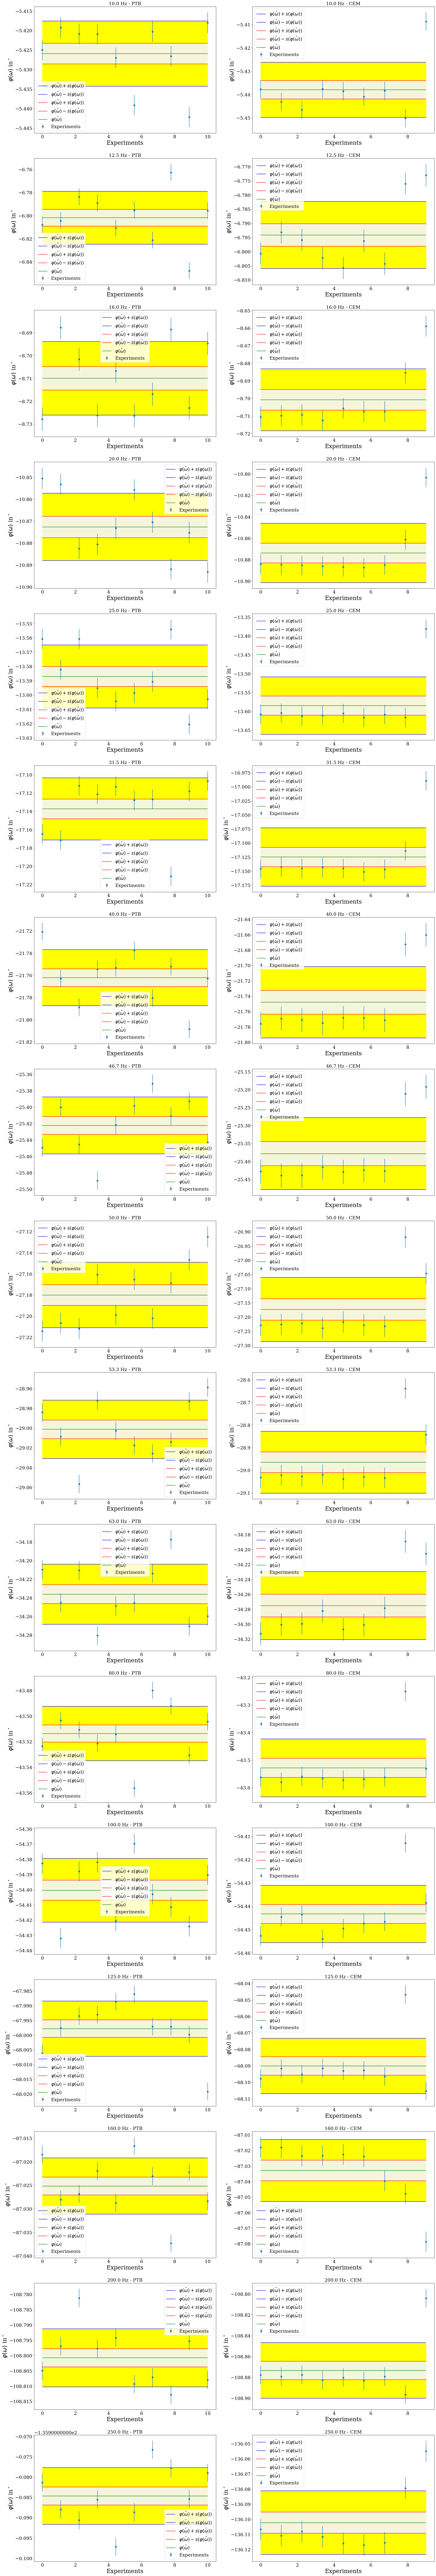

In [39]:
plot_phase(PTB_separated_by_freq,avg_std_PTB,st_sample_PTB,CEM_separated_by_freq_new,avg_std_CEM,st_sample_CEM)

## 3.2 En values

The En values for Magnitude, Phase have been calculated according to formula on the figure:
$$\frac{|\bar{x}_{PTB}-\bar{x}_{CEM}|}{\sqrt{{U^{2}}_{PTB}+{U^{2}}_{CEM}}}$$



<br>$x_{PTB}$ corresponds to the mean value at a specific frequency for  PTB
<br>$x_{CEM}$ corresponds to the mean value at a specific frequency for  CEM
<br>$U_{PTB}$ corresponds to the expanded measurement uncertainty of the mean value at a specific frequency for  PTB
<br>$U_{CEM}$ corresponds to the expanded measurement uncertainty of the mean value at a specific frequency CEM
<br>If:<br> |En|<=1.1 - the criteria is satisfied (the original condition is that |En|<=1.0. However, because of the practical reasons, this limit is sometimes enlarged for 10%).
<br>|En|>1.1 - the criteria is not satisfied.
<br>The order of laboratories is not important because it affects only the sign. That is why an absolute values are taken into account. 



In [40]:
#1
def calculate_En_values(df1,df2,df3,df4):
    En_values=np.empty((len(df1),2))

    En_values[:,0]=np.abs(((df1.iloc[:,1]-df2.iloc[:,1])/(2*(np.sqrt(df3.iloc[:,1]**2 +df4.iloc[:,1]**2)))))
    En_values[:,1]=np.abs(((df1.iloc[:,3]-df2.iloc[:,3])/(2*(np.sqrt(df3.iloc[:,3]**2 +df4.iloc[:,3]**2)))))
    return En_values 

In [41]:
En_values=calculate_En_values(avg_std_PTB,avg_std_CEM,st_sample_PTB,st_sample_CEM)

In [42]:
En_values_df=pd.DataFrame(En_values, columns=["Magnitude","Phase"])#"Excitation amplitude")

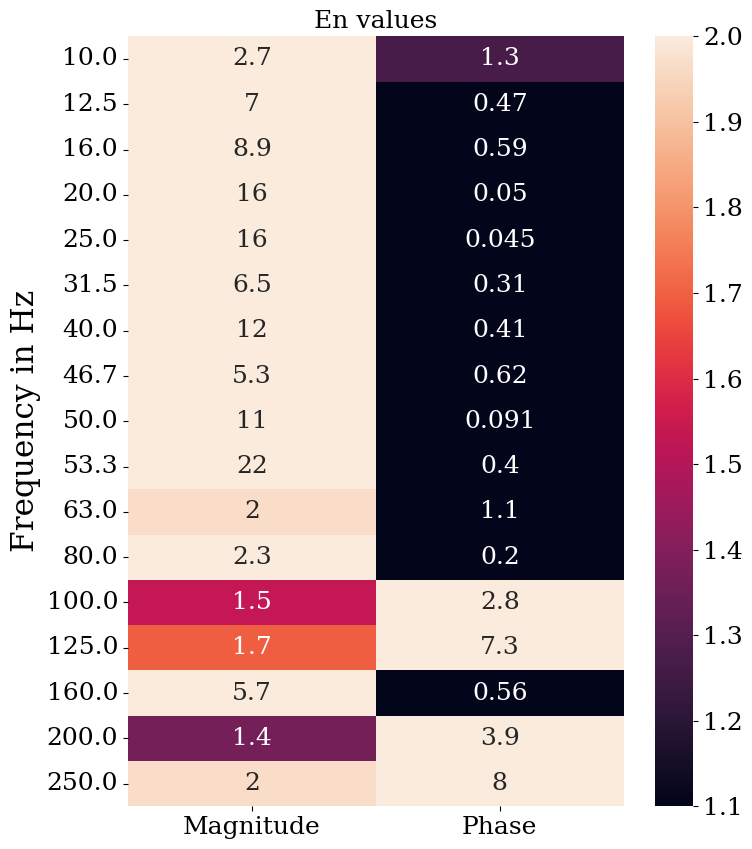

In [43]:
plt.figure(figsize=(8,10))
sns.heatmap(En_values_df, vmax=2, vmin=1.1,annot=True,yticklabels=PTB_separated_by_freq.keys(),xticklabels=["Magnitude","Phase"] )
plt.title("En values")
plt.ylabel("Frequency in Hz")
plt.show()


#excitation amp  - the en values does not have to be agreed because it is not targeted precisely

The calculated En values show disagreement of magnitudes at all frequencies, while good agreement of phase values is present in a range (12.5 - 80.0) Hz. Nevertheless,this approach is questionable when the test of variances is considered (2_ANOVA_for_experiments.ipynb)

# References

 https://www.investopedia.com/terms/c/coefficientofvariation.asp
<br>https://en.wikipedia.org/wiki/Weighted_arithmetic_mean
<br>https://en.wikipedia.org/wiki/Effective_sample_size
<br>https://online.stat.psu.edu/stat500/lesson/10/10.2/10.2.1
<br>https://www.marsja.se/levenes-bartletts-test-of-equality-homogeneity-of-variance-in-python/
<br>https://en.wikipedia.org/wiki/Weighted_arithmetic_mean
<br>https://en.wikipedia.org/wiki/Effective_sample_size
<br>https://online.stat.psu.edu/stat500/lesson/10/10.2/10.2.1
<br>https://iopscience.iop.org/article/10.1088/0026-1394/39/6/10